In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import glob
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LayerNormalization, Dropout, MultiHeadAttention, Input, Add, Flatten
from tensorflow.keras.models import Model
import pywt
import tensorflow as tf
from concurrent.futures import ThreadPoolExecutor

# Enable GPU usage
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Find CSV files
files = glob.glob(r'D:\A_NAUSHAD\E\Dataset\Book6.csv')

def wavelet_transform(data, wavelet='db1'):
    coeffs = pywt.wavedec(data, wavelet, mode='periodization')
    return coeffs

def inverse_wavelet_transform(coeffs, wavelet='db1'):
    return pywt.waverec(coeffs, wavelet, mode='periodization')

# Function to evaluate predictions
def evaluate_preds(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mslr = tf.keras.metrics.mean_squared_logarithmic_error(y_true, y_pred)

    return {
        "mae": mae.numpy().mean(),
        "mse": mse.numpy().mean(),
        "rmse": rmse.numpy().mean(),
        "mape": mape.numpy().mean(),
        "mslr": mslr.numpy().mean(),
    }

# Custom Transformer model
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = Add()([x, inputs])
    x = LayerNormalization(epsilon=1e-6)(x)
    
    x_ff = Dense(ff_dim, activation="relu")(x)
    x_ff = Dropout(dropout)(x_ff)
    x_ff = Dense(inputs.shape[-1])(x_ff)
    x = Add()([x, x_ff])
    x = LayerNormalization(epsilon=1e-6)(x)
    return x

def create_transformer_model(input_shape, head_size=256, num_heads=4, ff_dim=4, num_transformer_blocks=4, mlp_units=[128], dropout=0.1, mlp_dropout=0.1):
    inputs = Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = Flatten()(x)
    for dim in mlp_units:
        x = Dense(dim, activation="relu")(x)
        x = Dropout(mlp_dropout)(x)
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

# Function to save DataFrame to CSV
def save_to_csv(df, file_path):
    df.to_csv(file_path, index=False)

# Function to process and save results
def process_and_save_results(column, df, history, y_test_inverse, y_pred_inverse, model, X_train, feature_transformed):
    forecast_dates = pd.date_range(start='2023-01-28', end='2024-12-31', freq='H')
    df_forecast = pd.DataFrame(index=forecast_dates)

    feature_scaled = feature_transformed.reshape(-1, 1)
    scaler = MinMaxScaler()
    feature_scaled = scaler.fit_transform(feature_scaled)

    # Use the same length as the training data
    length = X_train.shape[1]
    forecast_generator = TimeseriesGenerator(feature_scaled, np.zeros(len(feature_scaled)), length=length, sampling_rate=1, batch_size=1)
    
    # Prepare forecast data
    forecast_data = np.array([x[0] for x in forecast_generator])
    
    # Reshape forecast_data to match X_train
    forecast_data = forecast_data.reshape((-1, X_train.shape[1], X_train.shape[2]))
    
    # Debug: Print shapes
    print("X_train shape:", X_train.shape)
    print("Forecast data shape:", forecast_data.shape)
    
    # Ensure the input shape matches the training shape
    if forecast_data.shape[1:] != X_train.shape[1:]:
        raise ValueError(f"Input shape mismatch: {forecast_data.shape[1:]} != {X_train.shape[1:]}")

    predicted_values_forecast = model.predict(forecast_data)
    predicted_values_forecast = scaler.inverse_transform(predicted_values_forecast)

    if len(predicted_values_forecast) > len(df_forecast):
        predicted_values_forecast = predicted_values_forecast[:len(df_forecast)]
    else:
        forecast_values = np.full((len(df_forecast), 1), np.nan)
        forecast_values[:len(predicted_values_forecast)] = predicted_values_forecast
        predicted_values_forecast = forecast_values

    df_forecast[column] = predicted_values_forecast
    df_forecast.to_csv(f'D:/A_NAUSHAD/E/RESULTS/FORE/Transformer_{column}_Wave_fore.csv')

    plt.figure(figsize=(12, 6))
    plt.plot(df_forecast.index, df_forecast[column], label='Forecasted')
    plt.xlabel('Hour')
    plt.ylabel(column)
    plt.legend()
    plt.title(f'Forecast of Hourly {column} concentration using Transformer')
    plt.show()
    
    pd.DataFrame(history.history['loss']).to_csv(f'D:/A_NAUSHAD/E/RESULTS/LOSS/Transformer_{column}_Wave_loss.csv')
    pd.DataFrame(history.history['val_loss']).to_csv(f'D:/A_NAUSHAD/E/RESULTS/LOSS/Transformer_{column}_Wave_val_loss.csv')

    predictions_train = model.predict(X_train)
    pd.DataFrame(predictions_train).to_csv(f'D:/A_NAUSHAD/E/RESULTS/PRED/Transformer_{column}_Wave_train_pred.csv')
    predictions_test = model.predict(X_test)
    pd.DataFrame(predictions_test).to_csv(f'D:/A_NAUSHAD/E/RESULTS/PRED/Transformer_{column}_Wave_test_pred.csv')

    eval_results = evaluate_preds(y_true=y_test_inverse, y_pred=y_pred_inverse)
    eval_df = pd.DataFrame.from_dict(eval_results, orient='index', columns=['value'])
    eval_df.to_csv(f'D:/A_NAUSHAD/E/RESULTS/EVAL/Transformer_{column}_Wave_eval.csv')


# Loop over files
for file in files:
    df = pd.read_csv(file, parse_dates=['Date'], index_col=['Date'])

    # Create a ThreadPoolExecutor for parallel file operations
    with ThreadPoolExecutor(max_workers=4) as executor:
        # List of tasks to execute
        tasks = []

        for column in df.columns:
            feature = df[[column]].values
            target = df[[column]].values

            feature_wavelet = wavelet_transform(feature)
            target_wavelet = wavelet_transform(target)

            feature_transformed = feature_wavelet[0]
            target_transformed = target_wavelet[0]

            X_train, X_test, y_train, y_test = train_test_split(feature_transformed, target_transformed, test_size=0.15, random_state=1, shuffle=False)
            X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=1, shuffle=False)

            X_train = np.expand_dims(X_train, axis=-1)
            X_val = np.expand_dims(X_val, axis=-1)
            X_test = np.expand_dims(X_test, axis=-1)

            # Create the Transformer model
            model = create_transformer_model(input_shape=(X_train.shape[1], X_train.shape[2]))
            
            lr_monitor = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=2, factor=0.5, cooldown=1)
            early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
            
            history = model.fit(
                X_train, y_train, 
                epochs=100,
                validation_data=(X_val, y_val),
                batch_size=128,
                callbacks=[lr_monitor, early_stopping],
                verbose=2
            )
            
            loss = model.evaluate(X_test)
            print(f'Test loss for column {column} using Transformer: {loss}')
            
            y_pred = model.predict(X_test)
            
            y_test_wavelet = list(target_wavelet)
            y_test_wavelet[0] = y_test
            y_pred_wavelet = list(target_wavelet)
            y_pred_wavelet[0] = y_pred.flatten()

            y_test_inverse = inverse_wavelet_transform(y_test_wavelet)
            y_pred_inverse = inverse_wavelet_transform(y_pred_wavelet)

            tasks.append(executor.submit(process_and_save_results, column, df, history, y_test_inverse, y_pred_inverse, model, X_train, feature_transformed))

        for task in tasks:
            task.result()


Epoch 1/100
184/184 - 14s - loss: 1832.6417 - val_loss: 1127.3617 - lr: 0.0010 - 14s/epoch - 78ms/step
Epoch 2/100
184/184 - 7s - loss: 1818.8718 - val_loss: 1116.5345 - lr: 0.0010 - 7s/epoch - 36ms/step
Epoch 3/100
184/184 - 7s - loss: 1805.1969 - val_loss: 1105.7971 - lr: 0.0010 - 7s/epoch - 36ms/step
Epoch 4/100
184/184 - 7s - loss: 1791.6132 - val_loss: 1095.1500 - lr: 0.0010 - 7s/epoch - 37ms/step
Epoch 5/100
184/184 - 7s - loss: 1778.1171 - val_loss: 1084.5796 - lr: 0.0010 - 7s/epoch - 36ms/step
Epoch 6/100
184/184 - 6s - loss: 1764.7168 - val_loss: 1074.0999 - lr: 0.0010 - 6s/epoch - 35ms/step
Epoch 7/100
184/184 - 6s - loss: 1751.4113 - val_loss: 1063.6951 - lr: 0.0010 - 6s/epoch - 35ms/step
Epoch 8/100
184/184 - 6s - loss: 1738.1904 - val_loss: 1053.3939 - lr: 0.0010 - 6s/epoch - 35ms/step
Epoch 9/100
184/184 - 7s - loss: 1725.0565 - val_loss: 1043.1481 - lr: 0.0010 - 7s/epoch - 35ms/step
Epoch 10/100


KeyboardInterrupt: 

C:\Users\rtvip\AppData\Roaming\Python\Python39\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"





Epoch 1/100

1958/1958 [==============================] - 37s 11ms/step - loss: 574.8549 - val_loss: 315.0235 - lr: 0.0010
Epoch 2/100
1958/1958 [==============================] - 22s 11ms/step - loss: 419.0543 - val_loss: 310.6925 - lr: 0.0010
Epoch 3/100
1958/1958 [==============================] - 21s 11ms/step - loss: 417.9985 - val_loss: 296.3141 - lr: 0.0010
Epoch 4/100
1958/1958 [==============================] - 21s 11ms/step - loss: 418.2657 - val_loss: 307.5594 - lr: 0.0010
Epoch 5/100
1958/1958 [==============================] - 21s 11ms/step - loss: 418.5378 - val_loss: 313.3710 - lr: 0.0010
Epoch 6/100
1958/1958 [==============================] - 21s 11ms/step - loss: 418.2505 - val_loss: 309.3216 - lr: 5.0000e-04
Epoch 7/100
1958/1958 [==============================] - 21s 10ms/step - loss: 418.0237 - val_loss: 310.5981 - lr: 5.0000e-04
Epoch 8/100
153/153 [==============================] - 1s 2ms/step - loss: 0.0000e+00
Test loss for column Karachi_PM2.5 using Transfo

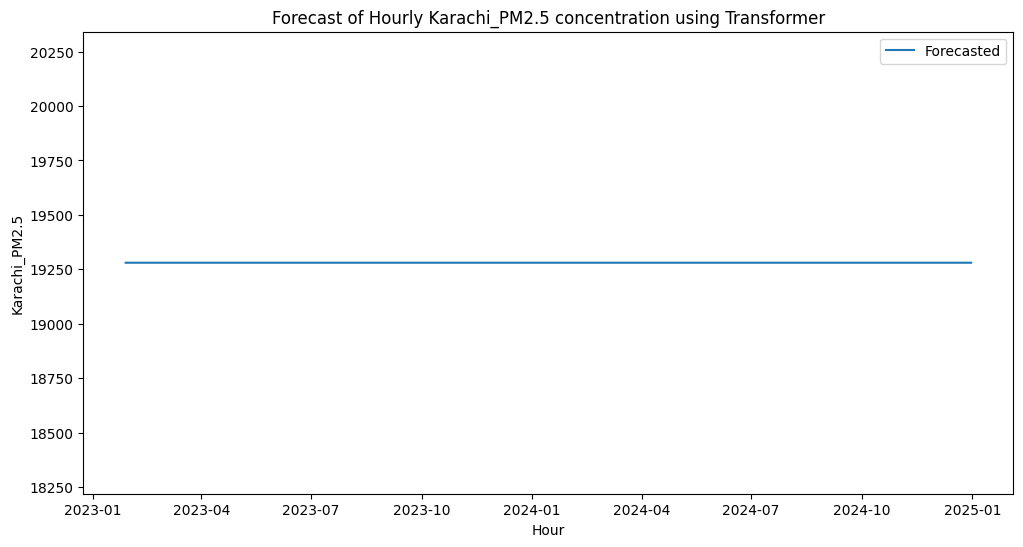

1958/1958 [==============================] - 46s 12ms/step - loss: 739.5564 - val_loss: 399.8395 - lr: 0.0010
Epoch 2/100
1958/1958 [==============================] - 21s 11ms/step - loss: 544.9009 - val_loss: 415.1448 - lr: 0.0010
Epoch 3/100
1958/1958 [==============================] - 21s 11ms/step - loss: 545.9965 - val_loss: 414.4285 - lr: 0.0010
Epoch 4/100
1958/1958 [==============================] - 22s 11ms/step - loss: 545.4053 - val_loss: 411.3904 - lr: 5.0000e-04
Epoch 5/100
1958/1958 [==============================] - 22s 11ms/step - loss: 545.0084 - val_loss: 398.8098 - lr: 5.0000e-04
Epoch 6/100
1958/1958 [==============================] - 21s 11ms/step - loss: 545.5452 - val_loss: 416.7155 - lr: 5.0000e-04
Epoch 7/100
1958/1958 [==============================] - 21s 11ms/step - loss: 545.0231 - val_loss: 406.0519 - lr: 5.0000e-04
Epoch 8/100
1958/1958 [==============================] - 21s 11ms/step - loss: 544.4836 - val_loss: 408.9650 - lr: 2.5000e-04
Epoch 9/100
1958

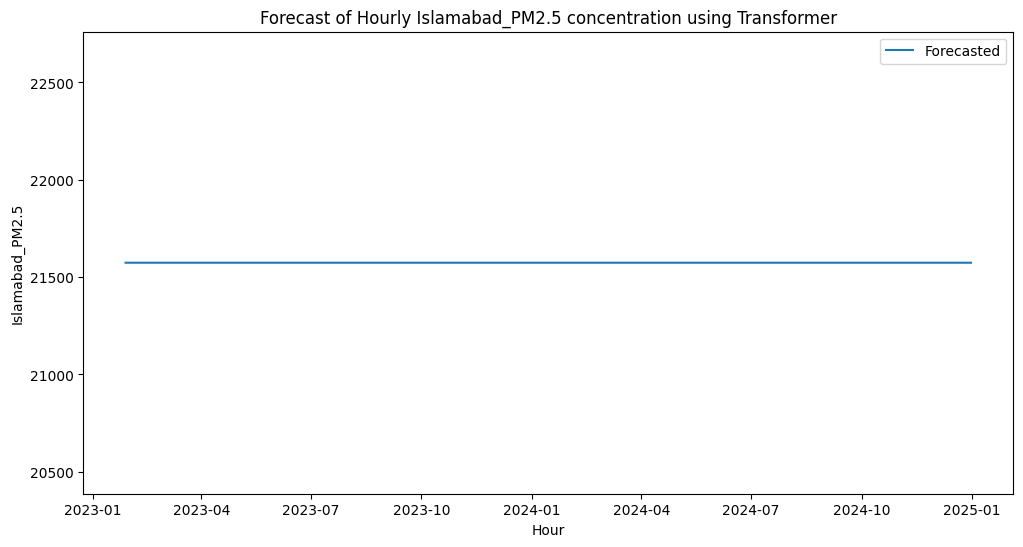

1958/1958 [==============================] - 46s 11ms/step - loss: 6428.8950 - val_loss: 2313.5908 - lr: 0.0010
Epoch 2/100
1958/1958 [==============================] - 22s 11ms/step - loss: 4988.6235 - val_loss: 2235.0549 - lr: 0.0010
Epoch 3/100
1958/1958 [==============================] - 21s 11ms/step - loss: 4991.6646 - val_loss: 2273.3596 - lr: 0.0010
Epoch 4/100
1958/1958 [==============================] - 21s 11ms/step - loss: 4988.8970 - val_loss: 2401.2012 - lr: 0.0010
Epoch 5/100
1958/1958 [==============================] - 21s 11ms/step - loss: 4985.5137 - val_loss: 2423.1780 - lr: 5.0000e-04
Epoch 6/100
1958/1958 [==============================] - 21s 11ms/step - loss: 4987.2271 - val_loss: 2422.4160 - lr: 5.0000e-04
Epoch 7/100
153/153 [==============================] - 1s 2ms/step - loss: 0.0000e+00
Test loss for column Lahore_PM2.5 using Transformer: 0.0
153/153 [==============================] - 1s 5ms/step
X_train shape: (23493, 2, 1)
Forecast data shape: (65032, 2, 1

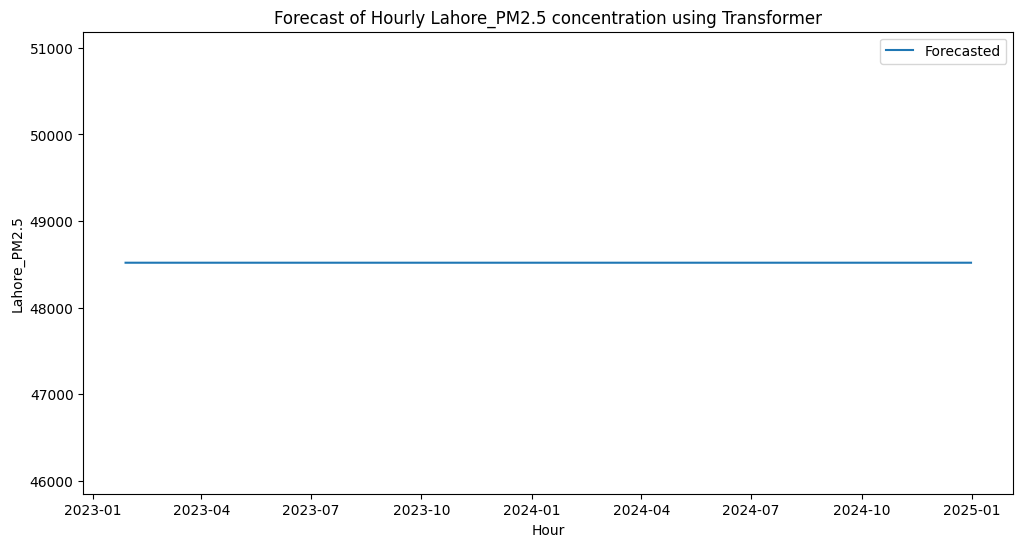

1958/1958 [==============================] - 46s 11ms/step - loss: 2098.9954 - val_loss: 1260.1123 - lr: 0.0010
Epoch 2/100
1958/1958 [==============================] - 21s 11ms/step - loss: 1470.7736 - val_loss: 1224.3650 - lr: 0.0010
Epoch 3/100
1958/1958 [==============================] - 21s 11ms/step - loss: 1472.6616 - val_loss: 1173.7074 - lr: 0.0010
Epoch 4/100
1958/1958 [==============================] - 21s 11ms/step - loss: 1468.9052 - val_loss: 1260.5040 - lr: 0.0010
Epoch 5/100
1958/1958 [==============================] - 21s 11ms/step - loss: 1467.1831 - val_loss: 1181.2943 - lr: 0.0010
Epoch 6/100
1958/1958 [==============================] - 21s 11ms/step - loss: 1470.5985 - val_loss: 1182.6669 - lr: 5.0000e-04
Epoch 7/100
1958/1958 [==============================] - 21s 11ms/step - loss: 1470.5631 - val_loss: 1228.2008 - lr: 5.0000e-04
Epoch 8/100
153/153 [==============================] - 1s 2ms/step - loss: 0.0000e+00
Test loss for column Peshawar_PM2.5 using Transfor

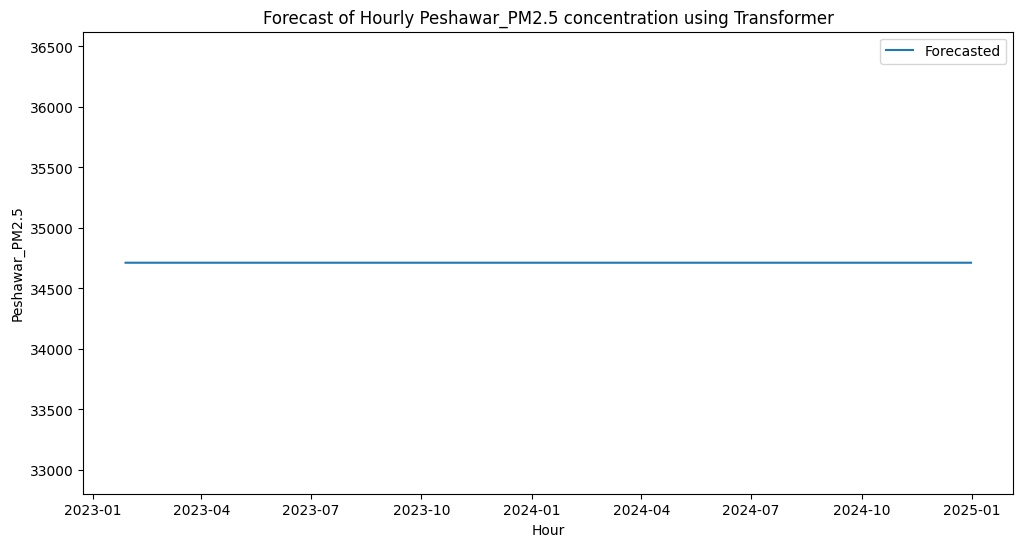

1958/1958 [==============================] - 49s 12ms/step - loss: 4712.9971 - val_loss: 2009.2728 - lr: 0.0010
Epoch 2/100
1958/1958 [==============================] - 22s 11ms/step - loss: 3705.3560 - val_loss: 2029.9563 - lr: 0.0010
Epoch 3/100
1958/1958 [==============================] - 23s 12ms/step - loss: 3713.2732 - val_loss: 2017.8076 - lr: 0.0010
Epoch 4/100
1958/1958 [==============================] - 23s 12ms/step - loss: 3704.7883 - val_loss: 2000.0968 - lr: 5.0000e-04
Epoch 5/100
1958/1958 [==============================] - 22s 11ms/step - loss: 3707.0764 - val_loss: 2030.3737 - lr: 5.0000e-04
Epoch 6/100
1958/1958 [==============================] - 22s 11ms/step - loss: 3705.3833 - val_loss: 2014.6511 - lr: 5.0000e-04
Epoch 7/100
1958/1958 [==============================] - 22s 11ms/step - loss: 3712.9895 - val_loss: 2003.1201 - lr: 2.5000e-04
Epoch 8/100
1958/1958 [==============================] - 22s 11ms/step - loss: 3705.6348 - val_loss: 2010.6740 - lr: 2.5000e-04


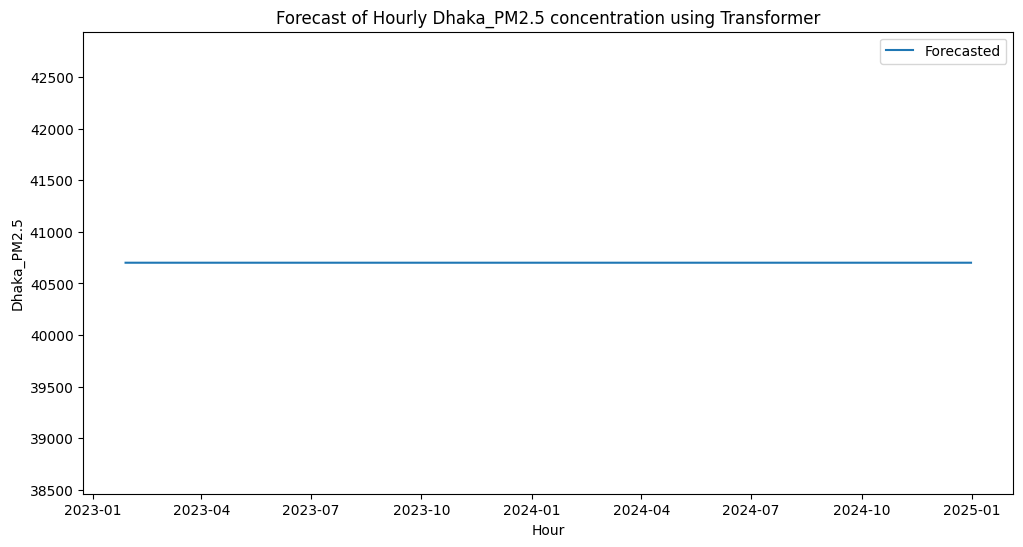

1958/1958 [==============================] - 46s 12ms/step - loss: 1288.6069 - val_loss: 958.4649 - lr: 0.0010
Epoch 2/100
1958/1958 [==============================] - 22s 11ms/step - loss: 1131.1641 - val_loss: 953.7077 - lr: 0.0010
Epoch 3/100
1958/1958 [==============================] - 24s 12ms/step - loss: 1130.1383 - val_loss: 964.7061 - lr: 0.0010
Epoch 4/100
1958/1958 [==============================] - 43s 22ms/step - loss: 1131.8114 - val_loss: 968.4540 - lr: 0.0010
Epoch 5/100
1958/1958 [==============================] - 42s 21ms/step - loss: 1130.6143 - val_loss: 957.5226 - lr: 5.0000e-04
Epoch 6/100
1958/1958 [==============================] - 37s 19ms/step - loss: 1128.7269 - val_loss: 962.0581 - lr: 5.0000e-04
Epoch 7/100
153/153 [==============================] - 1s 2ms/step - loss: 0.0000e+00
Test loss for column Beijing_PM2.5 using Transformer: 0.0
153/153 [==============================] - 2s 7ms/step
X_train shape: (23493, 2, 1)
Forecast data shape: (65032, 2, 1)
203

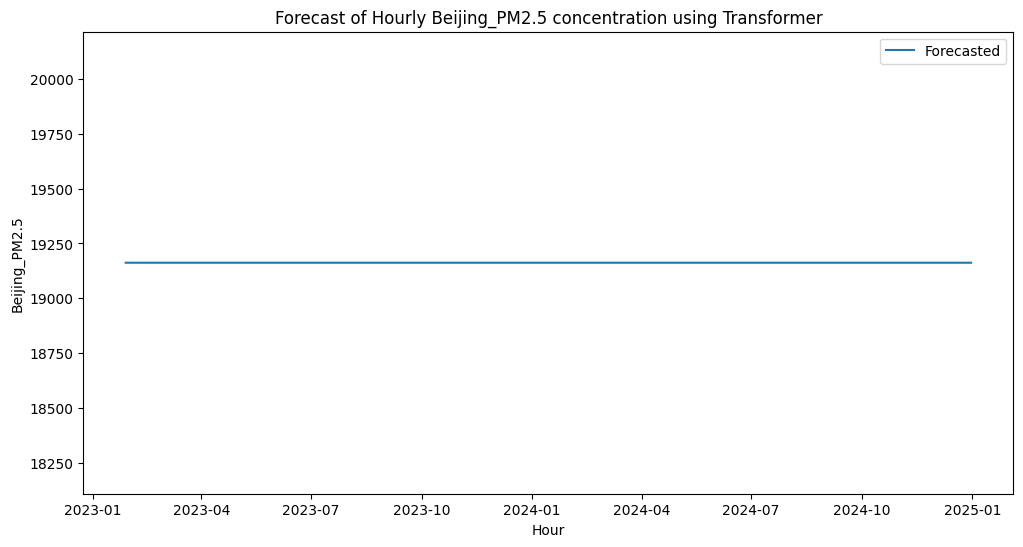

1958/1958 [==============================] - 62s 15ms/step - loss: 392.6835 - val_loss: 219.0073 - lr: 0.0010
Epoch 2/100
1958/1958 [==============================] - 28s 14ms/step - loss: 309.3964 - val_loss: 217.6733 - lr: 0.0010
Epoch 3/100
1958/1958 [==============================] - 27s 14ms/step - loss: 310.0619 - val_loss: 215.1224 - lr: 0.0010
Epoch 4/100
1958/1958 [==============================] - 27s 14ms/step - loss: 309.4133 - val_loss: 220.2626 - lr: 0.0010
Epoch 5/100
1958/1958 [==============================] - 27s 14ms/step - loss: 309.0876 - val_loss: 220.9060 - lr: 0.0010
Epoch 6/100
1958/1958 [==============================] - 26s 13ms/step - loss: 309.6421 - val_loss: 218.9872 - lr: 5.0000e-04
Epoch 7/100
1958/1958 [==============================] - 26s 13ms/step - loss: 309.1484 - val_loss: 220.7307 - lr: 5.0000e-04
Epoch 8/100
153/153 [==============================] - 1s 2ms/step - loss: 0.0000e+00
Test loss for column Shanghai_PM2.5 using Transformer: 0.0
153/1

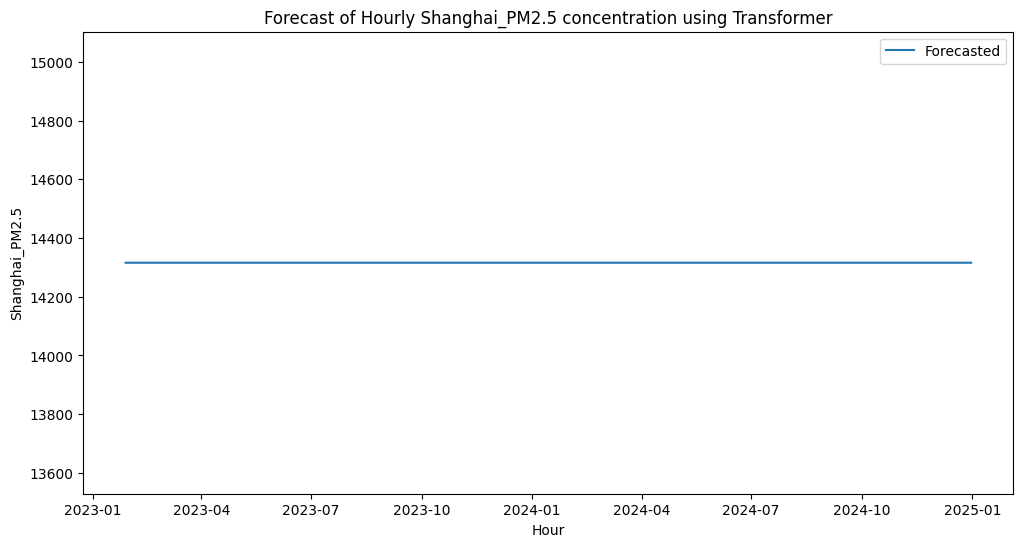

1958/1958 [==============================] - 56s 14ms/step - loss: 257.1946 - val_loss: 189.7092 - lr: 0.0010
Epoch 2/100
1958/1958 [==============================] - 26s 13ms/step - loss: 205.2506 - val_loss: 191.9276 - lr: 0.0010
Epoch 3/100
1958/1958 [==============================] - 26s 13ms/step - loss: 205.4175 - val_loss: 187.0053 - lr: 0.0010
Epoch 4/100
1958/1958 [==============================] - 26s 13ms/step - loss: 204.7603 - val_loss: 196.1069 - lr: 0.0010
Epoch 5/100
1958/1958 [==============================] - 25s 13ms/step - loss: 204.9682 - val_loss: 188.5346 - lr: 0.0010
Epoch 6/100
1958/1958 [==============================] - 25s 13ms/step - loss: 205.1245 - val_loss: 191.0344 - lr: 5.0000e-04
Epoch 7/100
1958/1958 [==============================] - 26s 13ms/step - loss: 205.0307 - val_loss: 190.2389 - lr: 5.0000e-04
Epoch 8/100
153/153 [==============================] - 1s 2ms/step - loss: 0.0000e+00
Test loss for column Chennai_PM2.5 using Transformer: 0.0
153/15

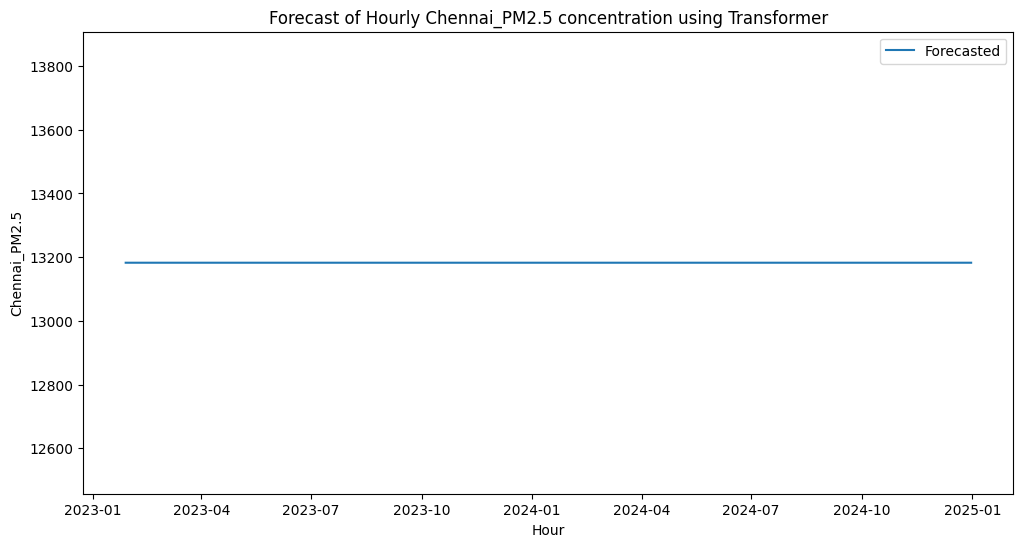

1958/1958 [==============================] - 55s 14ms/step - loss: 5106.0645 - val_loss: 2367.3298 - lr: 0.0010
Epoch 2/100
1958/1958 [==============================] - 26s 13ms/step - loss: 4072.8306 - val_loss: 2354.9731 - lr: 0.0010
Epoch 3/100
1958/1958 [==============================] - 26s 13ms/step - loss: 4069.3350 - val_loss: 2332.6887 - lr: 0.0010
Epoch 4/100
1958/1958 [==============================] - 25s 13ms/step - loss: 4073.3586 - val_loss: 2419.7629 - lr: 0.0010
Epoch 5/100
1958/1958 [==============================] - 25s 13ms/step - loss: 4075.2153 - val_loss: 2348.4087 - lr: 0.0010
Epoch 6/100
1958/1958 [==============================] - 25s 13ms/step - loss: 4075.5718 - val_loss: 2385.7263 - lr: 5.0000e-04
Epoch 7/100
1958/1958 [==============================] - 25s 13ms/step - loss: 4071.9326 - val_loss: 2389.6328 - lr: 5.0000e-04
Epoch 8/100
153/153 [==============================] - 1s 2ms/step - loss: 0.0000e+00
Test loss for column Delhi_PM2.5 using Transformer

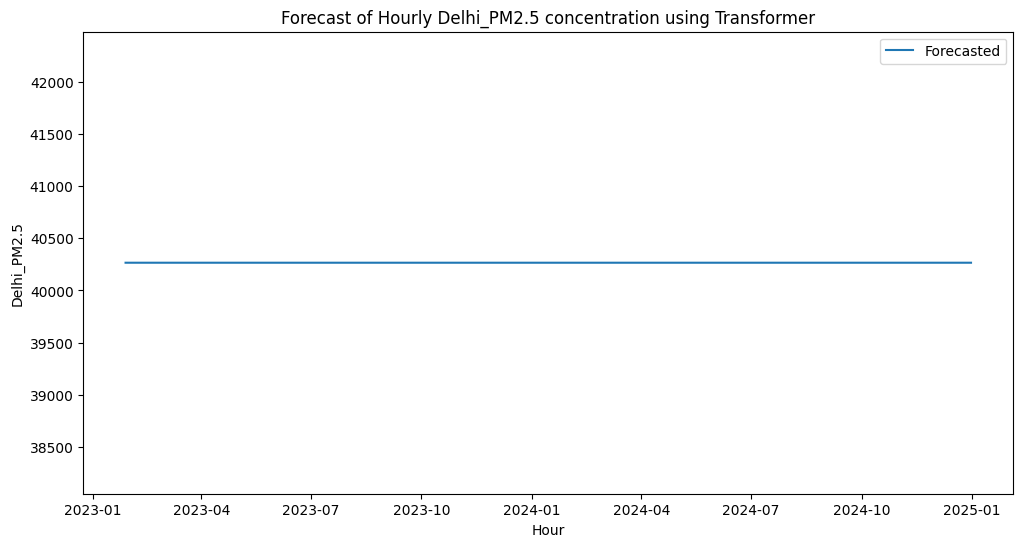

1958/1958 [==============================] - 52s 13ms/step - loss: 3406.0413 - val_loss: 1281.4009 - lr: 0.0010
Epoch 2/100
1958/1958 [==============================] - 24s 12ms/step - loss: 2905.6477 - val_loss: 1374.6815 - lr: 0.0010
Epoch 3/100
1958/1958 [==============================] - 24s 12ms/step - loss: 2905.2803 - val_loss: 1301.9211 - lr: 0.0010
Epoch 4/100
1958/1958 [==============================] - 24s 12ms/step - loss: 2901.9900 - val_loss: 1372.7714 - lr: 5.0000e-04
Epoch 5/100
1958/1958 [==============================] - 24s 12ms/step - loss: 2904.9912 - val_loss: 1379.8839 - lr: 5.0000e-04
Epoch 6/100
153/153 [==============================] - 1s 2ms/step - loss: 0.0000e+00
Test loss for column Kolkata_PM2.5 using Transformer: 0.0
153/153 [==============================] - 2s 6ms/step
X_train shape: (23493, 2, 1)
Forecast data shape: (65032, 2, 1)
2033/2033 [==============================] - 20s 10ms/step


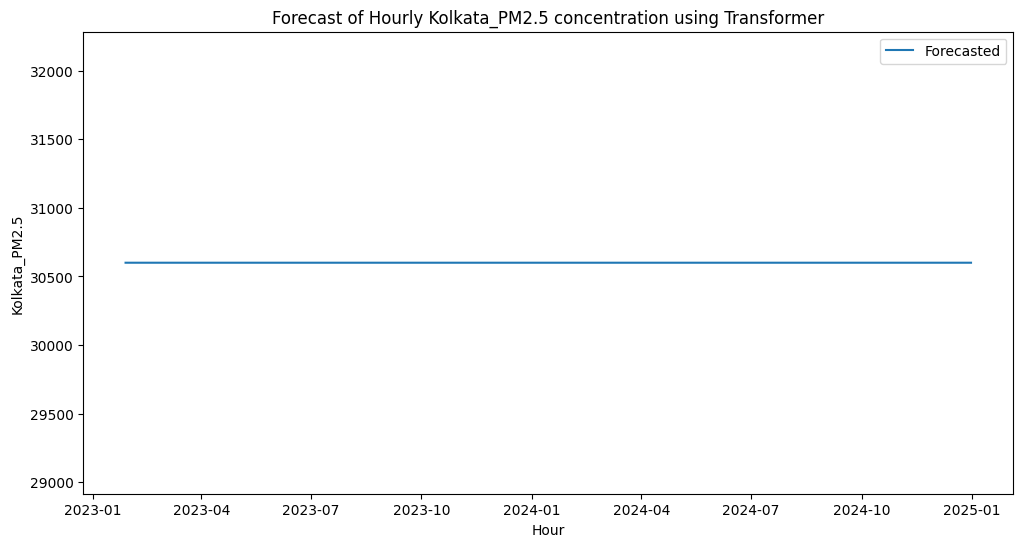

1958/1958 [==============================] - 53s 13ms/step - loss: 1303.5809 - val_loss: 765.9913 - lr: 0.0010
Epoch 2/100
1958/1958 [==============================] - 24s 12ms/step - loss: 1086.0188 - val_loss: 807.2312 - lr: 0.0010
Epoch 3/100
1958/1958 [==============================] - 24s 12ms/step - loss: 1085.2881 - val_loss: 723.1971 - lr: 0.0010
Epoch 4/100
1958/1958 [==============================] - 24s 12ms/step - loss: 1087.7013 - val_loss: 771.9841 - lr: 0.0010
Epoch 5/100
1958/1958 [==============================] - 24s 12ms/step - loss: 1087.2197 - val_loss: 744.7681 - lr: 0.0010
Epoch 6/100
1958/1958 [==============================] - 24s 12ms/step - loss: 1086.2496 - val_loss: 746.8182 - lr: 5.0000e-04
Epoch 7/100
1958/1958 [==============================] - 23s 12ms/step - loss: 1085.9723 - val_loss: 763.7140 - lr: 5.0000e-04
Epoch 8/100
153/153 [==============================] - 1s 2ms/step - loss: 0.0000e+00
Test loss for column Mumbai_PM2.5 using Transformer: 0.0


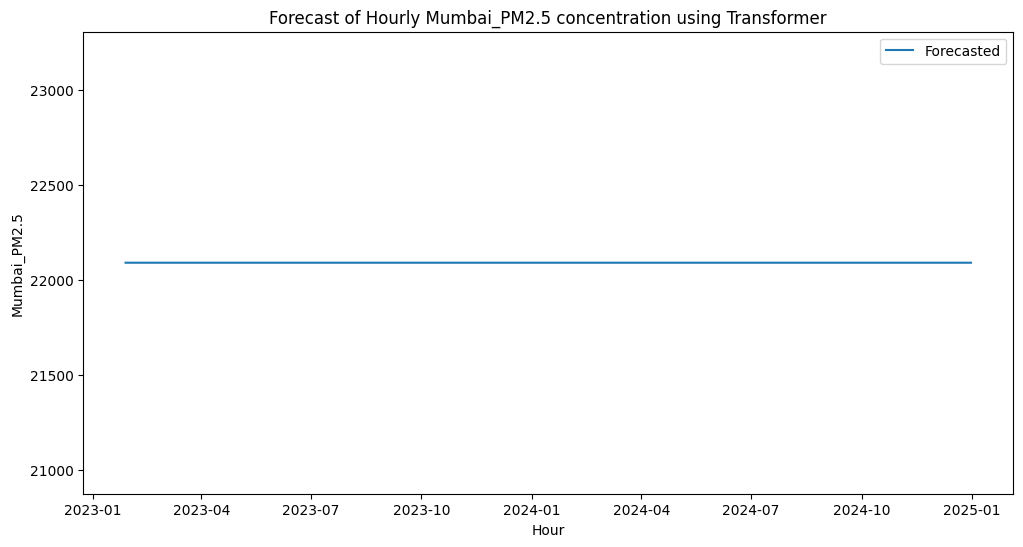

153/153 [==============================] - 1s 6ms/step


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import glob
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LayerNormalization, Dropout, MultiHeadAttention, Input, Add, Flatten
from tensorflow.keras.models import Model
import pywt
import tensorflow as tf
from concurrent.futures import ThreadPoolExecutor

# Enable GPU usage
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Find CSV files
files = glob.glob(r'D:\A_NAUSHAD\E\Dataset\Book6.csv')

def wavelet_transform(data, wavelet='db1'):
    coeffs = pywt.wavedec(data, wavelet, mode='periodization')
    return coeffs

def inverse_wavelet_transform(coeffs, wavelet='db1'):
    return pywt.waverec(coeffs, wavelet, mode='periodization')

# Function to evaluate predictions
def evaluate_preds(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mslr = tf.keras.metrics.mean_squared_logarithmic_error(y_true, y_pred)

    return {
        "mae": mae.numpy().mean(),
        "mse": mse.numpy().mean(),
        "rmse": rmse.numpy().mean(),
        "mape": mape.numpy().mean(),
        "mslr": mslr.numpy().mean(),
    }

# Custom Transformer model
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = Add()([x, inputs])
    x = LayerNormalization(epsilon=1e-6)(x)
        
    x_ff = Dense(ff_dim, activation="LeakyReLU")(x)
    x_ff = Dropout(dropout)(x_ff)
    x_ff = Dense(inputs.shape[-1])(x_ff)
    x = Add()([x, x_ff])
    x = LayerNormalization(epsilon=1e-6)(x)
    return x

def create_transformer_model(input_shape, head_size=12, num_heads=4, ff_dim=4, num_transformer_blocks=4, mlp_units=[64], dropout=0.1, mlp_dropout=0.1):
    inputs = Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = Flatten()(x)
    for dim in mlp_units:
        x = Dense(dim, activation="LeakyReLU")(x)
        x = Dropout(mlp_dropout)(x)
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='Nadam', loss='mse')
    return model

# Function to save DataFrame to CSV
def save_to_csv(df, file_path):
    df.to_csv(file_path, index=False)

# Function to process and save results
def process_and_save_results(column, df, history, y_test_inverse, y_pred_inverse, model, X_train, feature_transformed):
    forecast_dates = pd.date_range(start='2023-01-28', end='2024-12-31', freq='H')
    df_forecast = pd.DataFrame(index=forecast_dates)

    feature_scaled = feature_transformed.reshape(-1, 1)
    scaler = MinMaxScaler()
    feature_scaled = scaler.fit_transform(feature_scaled)

    # Use the same length as the training data
    length = X_train.shape[1]
    forecast_generator = TimeseriesGenerator(feature_scaled, np.zeros(len(feature_scaled)), length=length, sampling_rate=1, batch_size=1)
    
    # Prepare forecast data
    forecast_data = np.array([x[0] for x in forecast_generator])
    
    # Reshape forecast_data to match X_train
    forecast_data = forecast_data.reshape((-1, X_train.shape[1], X_train.shape[2]))
    
    # Debug: Print shapes
    print("X_train shape:", X_train.shape)
    print("Forecast data shape:", forecast_data.shape)
    
    # Ensure the input shape matches the training shape
    if forecast_data.shape[1:] != X_train.shape[1:]:
        raise ValueError(f"Input shape mismatch: {forecast_data.shape[1:]} != {X_train.shape[1:]}")

    predicted_values_forecast = model.predict(forecast_data)
    predicted_values_forecast = scaler.inverse_transform(predicted_values_forecast)

    if len(predicted_values_forecast) > len(df_forecast):
        predicted_values_forecast = predicted_values_forecast[:len(df_forecast)]
    else:
        forecast_values = np.full((len(df_forecast), 1), np.nan)
        forecast_values[:len(predicted_values_forecast)] = predicted_values_forecast
        predicted_values_forecast = forecast_values

    df_forecast[column] = predicted_values_forecast
    df_forecast.to_csv(f'D:/A_NAUSHAD/E/RESULTS/FORE/Transformer_{column}_Wave_fore.csv')

    plt.figure(figsize=(12, 6))
    plt.plot(df_forecast.index, df_forecast[column], label='Forecasted')
    plt.xlabel('Hour')
    plt.ylabel(column)
    plt.legend()
    plt.title(f'Forecast of Hourly {column} concentration using Transformer')
    plt.show()
    
    pd.DataFrame(history.history['loss']).to_csv(f'D:/A_NAUSHAD/E/RESULTS/LOSS/Transformer_{column}_Wave_loss.csv')
    pd.DataFrame(history.history['val_loss']).to_csv(f'D:/A_NAUSHAD/E/RESULTS/LOSS/Transformer_{column}_Wave_val_loss.csv')

    predictions_train = model.predict(X_train)
    pd.DataFrame(predictions_train).to_csv(f'D:/A_NAUSHAD/E/RESULTS/PRED/Transformer_{column}_Wave_train_pred.csv')
    predictions_test = model.predict(X_test)
    pd.DataFrame(predictions_test).to_csv(f'D:/A_NAUSHAD/E/RESULTS/PRED/Transformer_{column}_Wave_test_pred.csv')

    eval_results = evaluate_preds(y_true=y_test_inverse, y_pred=y_pred_inverse)
    eval_df = pd.DataFrame.from_dict(eval_results, orient='index', columns=['value'])
    eval_df.to_csv(f'D:/A_NAUSHAD/E/RESULTS/EVAL/Transformer_{column}_Wave_eval.csv')

# Loop over files
for file in files:
    df = pd.read_csv(file, parse_dates=['Date'], index_col=['Date'])
    #print(df)

    # Create a ThreadPoolExecutor for parallel file operations
    with ThreadPoolExecutor(max_workers=4) as executor:
        # List of tasks to execute
        tasks = []

        for column in df.columns:
            feature = df.values
            target = df[[column]].values
            
            
            feature_wavelet = wavelet_transform(feature)
            target_wavelet = wavelet_transform(target)


            feature_transformed = feature_wavelet[0]
            target_transformed = target_wavelet[0]

            X_train, X_test, y_train, y_test = train_test_split(feature_transformed, target_transformed, test_size=0.15, random_state=1, shuffle=False)
            X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=1, shuffle=False)

            X_train = np.expand_dims(X_train, axis=-1)
            X_val = np.expand_dims(X_val, axis=-1)
            X_test = np.expand_dims(X_test, axis=-1)

            # Create the Transformer model
            model = create_transformer_model(input_shape=(X_train.shape[1], X_train.shape[2]))
            
            lr_monitor = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=2, factor=0.5, cooldown=1)
            early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
            
            history = model.fit(
                X_train, y_train, 
                epochs=100,
                validation_data=(X_val, y_val),
                batch_size=12,
                callbacks=[lr_monitor, early_stopping],
                verbose=1
            )
            
            loss = model.evaluate(X_test)
            print(f'Test loss for column {column} using Transformer: {loss}')
            
#             plt.plot(model.history["loss"],label="loss")
#             plt.plot(model.history["val_loss"],label="val_loss")
#             plt.legend(loc="best")
#             plt.xlabel("No. Of Epochs")
#             plt.ylabel("mse score")
            
            y_pred = model.predict(X_test)
            
            y_test_wavelet = list(target_wavelet)
            y_test_wavelet[0] = y_test
            y_pred_wavelet = list(target_wavelet)
            y_pred_wavelet[0] = y_pred.flatten()

            y_test_inverse = inverse_wavelet_transform(y_test_wavelet)
            y_pred_inverse = inverse_wavelet_transform(y_pred_wavelet)

            tasks.append(executor.submit(process_and_save_results, column, df, history, y_test_inverse, y_pred_inverse, model, X_train, feature_transformed))

        for task in tasks:
            task.result()
